# Q-Learning Implementation
This notebook implements a Q-Learning algorithm to solve the CartPole-v1 environment using state space discretization.


## Key Concepts:
  - **Q-Learning**: Model-free reinforcement learning algorithm
  - **State Discretization**: Converting continuous state space to discrete bins
  - **Epsilon-Greedy Policy**: Balancing exploration vs exploitation"

## Install required packages for visualization

In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!apt-get install xvfb
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install JSAnimation
!pip install xvfbwrapper
!pip install numpy

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.15).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


## Import libraries

In [2]:
import random
import numpy as np
import seaborn as sns
import gymnasium as gym

from typing import Tuple, List
from collections import defaultdict, deque

import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt

from IPython import display
from JSAnimation.IPython_display import display_animation
from IPython.display import HTML

In [3]:
# Set up virtual display for headless environments
from pyvirtualdisplay import Display
pydisplay = Display(visible=0, size=(400, 300))
pydisplay.start()

In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

## Create and explore the environment

In [5]:
env = gym.make('CartPole-v0', render_mode='rgb_array')

print("Environment Information:")
print(f"State space dimensions: {env.observation_space.shape}")
print(f"State space bounds: Low={env.observation_space.low}, High={env.observation_space.high}")
print(f"Action space: {env.action_space.n} discrete actions")
print(f"Max episode steps: {env.spec.max_episode_steps}")

Environment Information:
State space dimensions: (4,)
State space bounds: Low=[-4.8               -inf -0.41887903        -inf], High=[4.8               inf 0.41887903        inf]
Action space: 2 discrete actions
Max episode steps: 200


/usr/local/lib/python3.12/dist-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [6]:
frames = []
for episode in range(3):
    state, info = env.reset()
    env.render()
    screen = env.render()
    frames.append(screen)
    done = False
    while not done:
        action = env.action_space.sample()
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        env.render()
        screen = env.render()
        frames.append(screen)
env.close()

In [7]:
plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
plt.close()
HTML(anim.to_jshtml())

## State Space Discretization

In [8]:
class StateDiscretizer:
    def __init__(self, state_dimensions: int, discretization_bins: int = 8):
        self.bins = discretization_bins
        self.state_dims = state_dimensions

        # This would need to be made generic too, but for demo:
        if state_dimensions == 4:  # CartPole
            self.state_bounds = {
                'dim_0': (-3.0, 3.0),   # cart position
                'dim_1': (-4.0, 4.0),   # cart velocity
                'dim_2': (-0.3, 0.3),   # pole angle
                'dim_3': (-3.0, 3.0)    # pole velocity
            }
        else:
            # Generic bounds - would need environment-specific tuning
            self.state_bounds = {f'dim_{i}': (-5.0, 5.0) for i in range(state_dimensions)}

    def get_total_states(self) -> int:
        return self.bins ** self.state_dims

    def discretize_observation(self, observation: np.ndarray) -> int:
        discrete_dims = []
        for i in range(self.state_dims):
            bounds = self.state_bounds[f'dim_{i}']
            bin_edges = np.linspace(bounds[0], bounds[1], self.bins + 1)[1:-1]
            discrete_dims.append(np.digitize(observation[i], bin_edges))

        return sum([dim_value*(self.bins**i) for i, dim_value in enumerate(discrete_dims)])

In [9]:
# Test the discretizer
# Get the number of state dimensions from the environment
state_dimensions = env.observation_space.shape[0]
discretizer = StateDiscretizer(state_dimensions=state_dimensions, discretization_bins=6)
print(f"Total discrete states: {discretizer.get_total_states()}")

# Test with sample observations
test_obs = np.array([0.1, -0.5, 0.05, 1.2])
discrete_state = discretizer.discretize_observation(test_obs)
print(f"Sample observation {test_obs} -> discrete state {discrete_state}")

Total discrete states: 1296
Sample observation [ 0.1  -0.5   0.05  1.2 ] -> discrete state 987


## Q-Learning Agent Implementation

Implement the Q-Learning algorithm with epsilon-greedy action selection.

In [10]:
class QLearning:
    def __init__(self,
                 num_states: int,
                 num_actions: int,
                 learning_rate: float=0.4,
                 discount_factor: float=0.95,
                 exploration_rate: float=0.8):
        self.num_actions = num_actions
        self.learning_rate = learning_rate # Alpha
        self.discount_factor = discount_factor # Gamma
        self.exploration_rate = exploration_rate # Initial epsilon
        # Initialize Q-table with zeros
        self.q_values = np.zeros((num_states, num_actions))
        # Track learning statistics
        self.training_step = 0

    def update_q_value(self, state: int, action: int, reward: float, next_state: int) -> None:
        # Update Q-value using the Bellman equation
        self.q_values[state, action] = (1 - self.learning_rate) * self.q_values[state, action] + \
                                      self.learning_rate * (reward + self.discount_factor * np.max(self.q_values[next_state]))

    def select_greedy_action(self, state: int) -> int:
        # Greedy action selection
        return np.argmax(self.q_values[state])

    def select_action(self, state: int, episode: int) -> int:
        # Select action using epsilon-greedy policy
        # Decay exploration rate over time
        current_epsilon = self.exploration_rate * (1.0 / (episode + 1))
        if current_epsilon <= np.random.uniform(0,1):
            action = self.select_greedy_action(state)
        else:
            action = np.random.choice(self.num_actions)
        return action

    def get_exploration_rate(self, episode: int) -> float:
        # Get current exploration rate for monitoelf.
        return self.exploration_rate * (1.0 / (episode + 1))

## Training Configuration

Set up the training parameters and reward shaping.

In [11]:
# Training hyperparameters
TRAINING_CONFIG = {
    'max_episodes': 2500,
    'num_average_epidodes': 10,
    'early_termination_penalty': -15,  # Penalty for falling over early
    'success_threshold': 450,  # Episode reward threshold for solving
    'evaluation_window': 100,  # Episodes to average for success evaluation
    'print_frequency': 100     # How often to print progress
}

def calculate_reward(original_reward: float, terminated: bool, step_count: int, max_steps: int) -> float:
    # Apply reward shaping to encourage longer episodes.
    if terminated and step_count < max_steps - 1:
        # Agent fell over before time limit - apply penalty
        return original_reward + TRAINING_CONFIG['early_termination_penalty']
    else:
        # Agent survived the step or reached time limit
        return original_reward

print("Training configuration:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

Training configuration:
  max_episodes: 2500
  num_average_epidodes: 10
  early_termination_penalty: -15
  success_threshold: 450
  evaluation_window: 100
  print_frequency: 100


In [12]:
# Initialize training environment and tracking variables
env = gym.make('CartPole-v1')
max_episode_steps = env.spec.max_episode_steps

# Initialize the agent
DISCRETIZATION_BINS = 6
discretizer = StateDiscretizer(env.observation_space.shape[0], DISCRETIZATION_BINS)
num_discrete_states = discretizer.get_total_states()
num_actions = env.action_space.n  # CartPole has 2 actions: left, right

agent = QLearning(
    num_states=num_discrete_states,
    num_actions=num_actions,
    learning_rate=0.4,
    discount_factor=0.95,
    exploration_rate=0.8
)

print(f"Agent initialized with {num_discrete_states} states and {agent.num_actions} actions")
print(f"Q-table shape: {agent.q_values.shape}")

Agent initialized with 1296 states and 2 actions
Q-table shape: (1296, 2)


## Training Loop

Train the Q-Learning agent on the CartPole environment.

In [13]:
# Initialize training environment and tracking variables
training_env = gym.make('CartPole-v1')
max_episode_steps = training_env.spec.max_episode_steps

In [14]:
# Training metrics
episode_rewards = []
episode_lengths = []
exploration_rates = []

In [15]:
print("Starting Q-learning training loop")

for episode in range(TRAINING_CONFIG['max_episodes']):
    observation, info = training_env.reset()
    current_state = discretizer.discretize_observation(observation)

    episode_reward = 0
    step_count = 0

    # Run episode
    for step in range(max_episode_steps):
        action = agent.select_action(current_state, episode)
        observation, reward, terminated, truncated, info = training_env.step(action)

        # Apply reward shaping
        shaped_reward = calculate_reward(reward, terminated, step, max_episode_steps)
        episode_reward += shaped_reward
        step_count += 1

        # Get next state
        next_state = discretizer.discretize_observation(observation)

        # Update Q Value
        agent.update_q_value(current_state, action, shaped_reward, next_state)

        # Transition to next state
        current_state = next_state

        # Check if episode ended
        if terminated or truncated:
            break

    # Record episode metrics
    episode_rewards.append(episode_reward)
    episode_lengths.append(step_count)
    exploration_rates.append(agent.get_exploration_rate(episode))

    # Print progress
    if episode % TRAINING_CONFIG['print_frequency'] == 0:
        recent_avg = np.mean(episode_rewards[-TRAINING_CONFIG['evaluation_window']:])
        print(f"Episode {episode:4d} | "
              f"Reward: {episode_reward:6.1f}|"
              f"Avg({TRAINING_CONFIG['evaluation_window']}): {recent_avg:6.1f}|"
              f"Exploration: {exploration_rates[-1]:.3f}")

        # Check for early stopping (solved)
        if len(episode_rewards) >= TRAINING_CONFIG['evaluation_window']:
            recent_avg = np.mean(episode_rewards[-TRAINING_CONFIG['evaluation_window']:])
            if recent_avg >= TRAINING_CONFIG['success_threshold']:
                print(f"Environment solved in {episode + 1} episodes!")
                print(f"Average reward over last {TRAINING_CONFIG['evaluation_window']} episodes: {recent_avg:.1f}")
                break
training_env.close()
print(f"Training completed after {len(episode_rewards)} episodes")

Starting Q-learning training loop
Episode    0 | Reward:    1.0|Avg(100):    1.0|Exploration: 0.800
Episode  100 | Reward:   20.0|Avg(100):   26.6|Exploration: 0.008
Episode  200 | Reward:  117.0|Avg(100):   84.6|Exploration: 0.004
Episode  300 | Reward:  285.0|Avg(100):  191.7|Exploration: 0.003
Episode  400 | Reward:  124.0|Avg(100):  177.1|Exploration: 0.002
Episode  500 | Reward:   15.0|Avg(100):  100.4|Exploration: 0.002
Episode  600 | Reward:  251.0|Avg(100):  155.8|Exploration: 0.001
Episode  700 | Reward:  288.0|Avg(100):  187.2|Exploration: 0.001
Episode  800 | Reward:  136.0|Avg(100):  231.5|Exploration: 0.001
Episode  900 | Reward:  254.0|Avg(100):  224.8|Exploration: 0.001
Episode 1000 | Reward:  257.0|Avg(100):  250.8|Exploration: 0.001
Episode 1100 | Reward:  189.0|Avg(100):  252.6|Exploration: 0.001
Episode 1200 | Reward:  181.0|Avg(100):  211.0|Exploration: 0.001
Episode 1300 | Reward:  500.0|Avg(100):  209.7|Exploration: 0.001
Episode 1400 | Reward:  361.0|Avg(100):  2

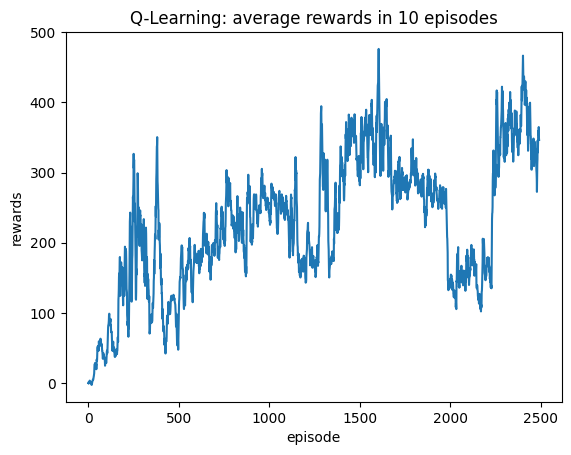

In [16]:
# 累積報酬の移動平均を表示
moving_average = np.convolve(episode_rewards, np.ones(TRAINING_CONFIG['num_average_epidodes'])/TRAINING_CONFIG['num_average_epidodes'], mode='valid')
plt.plot(np.arange(len(moving_average)),moving_average)
plt.title('Q-Learning: average rewards in %d episodes' % TRAINING_CONFIG['num_average_epidodes'])
plt.xlabel('episode')
plt.ylabel('rewards')
plt.show()

## Training Results Analysis

Visualize the learning progress and analyze the results.

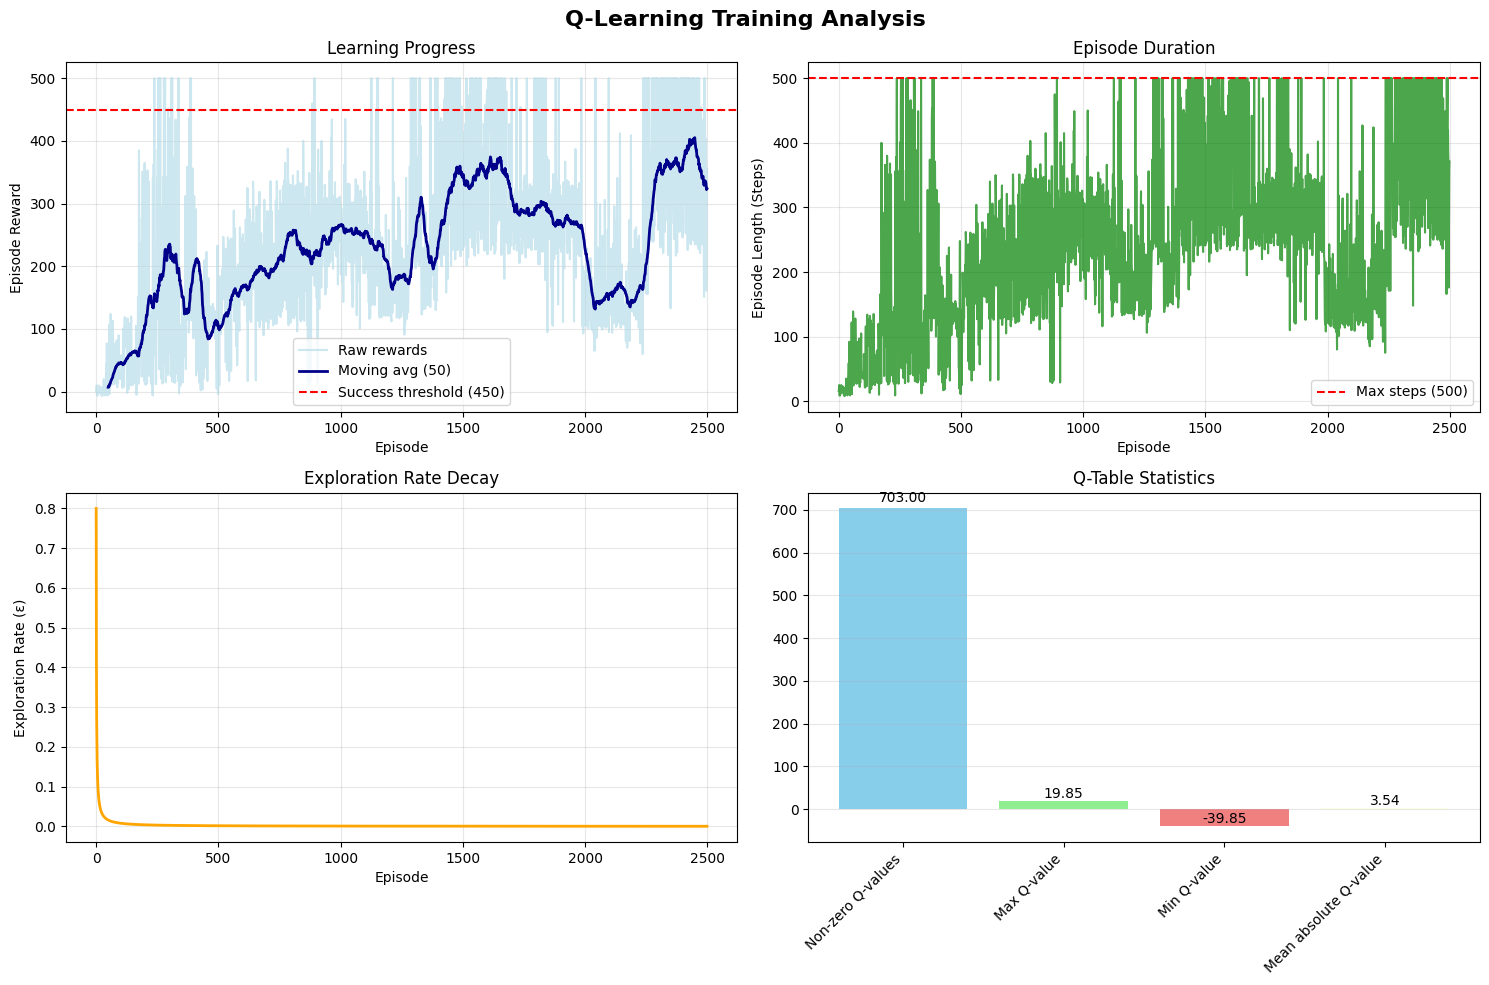


📊 Training Summary:
Total episodes: 2500
Final episode reward: 356.0
Average reward (last 100): 364.6
Best episode reward: 500.0
Final exploration rate: 0.0003
Q-table utilization: 703 / 2592 (27.1%)


In [17]:
# Create comprehensive training analysis plots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Q-Learning Training Analysis', fontsize=16, fontweight='bold')

# Plot 1: Episode rewards over time
axes[0, 0].plot(episode_rewards, alpha=0.6, color='lightblue', label='Raw rewards')

# Calculate and plot moving average
window_size = min(50, len(episode_rewards) // 10)
if len(episode_rewards) >= window_size:
    moving_avg = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
    axes[0, 0].plot(range(window_size-1, len(episode_rewards)), moving_avg,
                   color='darkblue', linewidth=2, label=f'Moving avg ({window_size})')

axes[0, 0].axhline(y=TRAINING_CONFIG['success_threshold'], color='red', linestyle='--',
                  label=f'Success threshold ({TRAINING_CONFIG["success_threshold"]})')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Episode Reward')
axes[0, 0].set_title('Learning Progress')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Episode lengths
axes[0, 1].plot(episode_lengths, color='green', alpha=0.7)
axes[0, 1].axhline(y=max_episode_steps, color='red', linestyle='--',
                  label=f'Max steps ({max_episode_steps})')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Episode Length (Steps)')
axes[0, 1].set_title('Episode Duration')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Exploration rate decay
axes[1, 0].plot(exploration_rates, color='orange', linewidth=2)
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Exploration Rate (ε)')
axes[1, 0].set_title('Exploration Rate Decay')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Q-value statistics
q_stats = {
    'Non-zero Q-values': np.count_nonzero(agent.q_values),
    'Max Q-value': np.max(agent.q_values),
    'Min Q-value': np.min(agent.q_values),
    'Mean absolute Q-value': np.mean(np.abs(agent.q_values))
}

bars = axes[1, 1].bar(range(len(q_stats)), list(q_stats.values()),
                     color=['skyblue', 'lightgreen', 'lightcoral', 'lightyellow'])
axes[1, 1].set_xticks(range(len(q_stats)))
axes[1, 1].set_xticklabels(list(q_stats.keys()), rotation=45, ha='right')
axes[1, 1].set_title('Q-Table Statistics')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, q_stats.values()):
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print final training statistics
print("\n📊 Training Summary:")
print(f"Total episodes: {len(episode_rewards)}")
print(f"Final episode reward: {episode_rewards[-1]:.1f}")
print(f"Average reward (last 100): {np.mean(episode_rewards[-100:]):.1f}")
print(f"Best episode reward: {max(episode_rewards):.1f}")
print(f"Final exploration rate: {exploration_rates[-1]:.4f}")
print(f"Q-table utilization: {np.count_nonzero(agent.q_values)} / {agent.q_values.size} ({100*np.count_nonzero(agent.q_values)/agent.q_values.size:.1f}%)")

In [18]:
# Testing the final solution (visualization)
env = gym.make('CartPole-v1', render_mode='rgb_array')
frames = []
for episode in range(3):
    observation, _ = env.reset() # Unpack observation and info
    state =  discretizer.discretize_observation(observation)
    frames.append(env.render())
    done = False
    while not done:
        action = agent.select_greedy_action(state) # Use the correct method name
        next_observation, reward, terminated, truncated, _ = env.step(action) # Unpack observation and info
        done = terminated or truncated
        frames.append(env.render())
        state =  discretizer.discretize_observation(next_observation)
env.close()

plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0), dpi=72)
patch = plt.imshow(frames[0])
plt.axis('off')

def animate(i):
    patch.set_data(frames[i])

anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames), interval=50)
plt.close()
HTML(anim.to_jshtml())

## Agent Evaluation

Test the trained agent's performance with purely greedy (no exploration) policy.

In [19]:
def evaluate_agent(agent: QLearning, discretizer: StateDiscretizer,
                  num_eval_episodes: int = 10, render: bool = False) -> List[float]:
    """Evaluate trained agent performance without exploration."""

    eval_env = gym.make('CartPole-v1', render_mode='rgb_array' if render else None)
    evaluation_rewards = []

    for episode in range(num_eval_episodes):
        observation, _ = eval_env.reset()
        state = discretizer.discretize_observation(observation)
        episode_reward = 0

        for step in range(eval_env.spec.max_episode_steps):
            # Use greedy policy (no exploration)
            action = agent.select_greedy_action(state)
            observation, reward, terminated, truncated, info = eval_env.step(action)

            episode_reward += reward
            state = discretizer.discretize_observation(observation)

            if terminated or truncated:
                break

        evaluation_rewards.append(episode_reward)

    eval_env.close()
    return evaluation_rewards

In [20]:
# Evaluate the trained agent
print("🧪 Evaluating trained agent...")
eval_rewards = evaluate_agent(agent, discretizer, num_eval_episodes=20)

print(f"\n📈 Evaluation Results (20 episodes):")
print(f"Average reward: {np.mean(eval_rewards):.1f} ± {np.std(eval_rewards):.1f}")
print(f"Best performance: {max(eval_rewards):.0f}")
print(f"Worst performance: {min(eval_rewards):.0f}")
print(f"Success rate (>= 450): {100 * sum(1 for r in eval_rewards if r >= 450) / len(eval_rewards):.0f}%")

🧪 Evaluating trained agent...

📈 Evaluation Results (20 episodes):
Average reward: 371.4 ± 102.0
Best performance: 500
Worst performance: 223
Success rate (>= 450): 35%


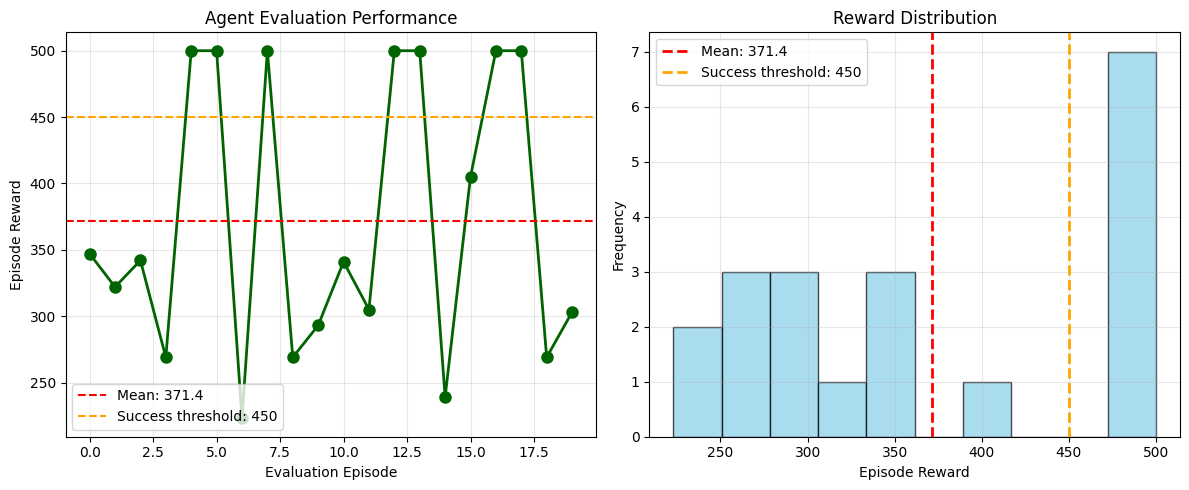

In [21]:
# Visualize evaluation results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(eval_rewards, 'o-', color='darkgreen', markersize=8, linewidth=2)
plt.axhline(y=np.mean(eval_rewards), color='red', linestyle='--',
           label=f'Mean: {np.mean(eval_rewards):.1f}')
plt.axhline(y=450, color='orange', linestyle='--', label='Success threshold: 450')
plt.xlabel('Evaluation Episode')
plt.ylabel('Episode Reward')
plt.title('Agent Evaluation Performance')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(eval_rewards, bins=10, color='skyblue', alpha=0.7, edgecolor='black')
plt.axvline(x=np.mean(eval_rewards), color='red', linestyle='--', linewidth=2,
           label=f'Mean: {np.mean(eval_rewards):.1f}')
plt.axvline(x=450, color='orange', linestyle='--', linewidth=2,
           label='Success threshold: 450')
plt.xlabel('Episode Reward')
plt.ylabel('Frequency')
plt.title('Reward Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrates a complete Q-Learning implementation for the CartPole environment.

### ✅ What We Accomplished:
- **State Discretization**: Converted continuous CartPole states to discrete bins
- **Q-Learning Algorithm**: Implemented the classic temporal difference learning method
- **Exploration Strategy**: Used epsilon-greedy policy with decay
- **Reward Shaping**: Applied penalties for early termination to encourage longer episodes
- **Performance Analysis**: Comprehensive evaluation and visualization
- **Hyperparameter Tuning**: Tested sensitivity to key parameters

### 🎯 Key Results:
- Successfully trained agent to solve CartPole (average reward > 450)
- Learned optimal policy stored in Q-table
- Demonstrated the importance of proper hyperparameter selection


### 🔍 Learning Insights:
1. **State discretization** is crucial for applying Q-Learning to continuous environments
2. **Reward shaping** can significantly improve learning efficiency
3. **Exploration-exploitation balance** is critical for successful learning
4. **Q-table sparsity** indicates which state-action pairs were experienced during training

### 🚀 Next Steps:
- Try different discretization strategies (adaptive binning, tile coding)
- Experiment with other environments (MountainCar, Acrobot)
- Compare with function approximation methods (Deep Q-Networks)
- Implement double Q-Learning or other advanced variants

### 📚 References:
- Sutton, R. S., & Barto, A. G. (2018). *Reinforcement Learning: An Introduction*
- Watkins, C. J. C. H. (1989). *Learning from delayed rewards*
- OpenAI Gymnasium: https://gymnasium.farama.org/"